# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [12]:
!pip install palmerpenguins
import pandas as pd
import numpy as np
from palmerpenguins import load_penguins
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve

from plotnine import *

In [5]:
penguins = load_penguins()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [8]:
penguins = penguins.dropna()

y = penguins["species"]
X = penguins.drop(columns=["species"])

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X.head()


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Dream,island_Torgersen,sex_male
0,39.1,18.7,181.0,3750.0,2007,False,True,True
1,39.5,17.4,186.0,3800.0,2007,False,True,False
2,40.3,18.0,195.0,3250.0,2007,False,True,False
4,36.7,19.3,193.0,3450.0,2007,False,True,False
5,39.3,20.6,190.0,3650.0,2007,False,True,True


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])


In [13]:
#KNN (3 and 7)
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train_scaled, y_train)

knn7 = KNeighborsClassifier(n_neighbors=7)
knn7.fit(X_train_scaled, y_train)

#Decision Trees (3 and 6)
tree3 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree3.fit(X_train, y_train)

tree6 = DecisionTreeClassifier(max_depth=6, random_state=42)
tree6.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [23]:
def evaluate(model, scaled): #help
    if scaled:
        preds = model.predict(X_test_scaled)
        probs = model.predict_proba(X_test_scaled)
    else:
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)

    cm = confusion_matrix(y_test, preds)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average=None)
    rec = recall_score(y_test, preds, average=None)
    f1 = f1_score(y_test, preds, average=None)
    auc = roc_auc_score(y_test, probs, multi_class="ovr")

    return cm, acc, prec, rec, f1, auc

results = {
    "KNN-3": evaluate(knn3, scaled=True),
    "KNN-7": evaluate(knn7, scaled=True),
    "Tree-3": evaluate(tree3, scaled=False),
    "Tree-6": evaluate(tree6, scaled=False)
}

for name, vals in results.items():
    cm, acc, prec, rec, f1, auc = vals
    print(name)
    print(cm)
    print(acc)
    print(prec)
    print(rec)
    print(f1)
    print(auc)

KNN-3
[[28  1  0]
 [ 1 13  0]
 [ 0  0 24]]
0.9701492537313433
[0.96551724 0.92857143 1.        ]
[0.96551724 0.92857143 1.        ]
[0.96551724 0.92857143 1.        ]
0.9992482833629291
KNN-7
[[29  0  0]
 [ 0 14  0]
 [ 0  0 24]]
1.0
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
1.0
Tree-3
[[29  0  0]
 [ 1 13  0]
 [ 2  0 22]]
0.9552238805970149
[0.90625 1.      1.     ]
[1.         0.92857143 0.91666667]
[0.95081967 0.96296296 0.95652174]
0.9681180151636953
Tree-6
[[26  3  0]
 [ 0 14  0]
 [ 2  0 22]]
0.9253731343283582
[0.92857143 0.82352941 1.        ]
[0.89655172 1.         0.91666667]
[0.9122807  0.90322581 0.95652174]
0.9506638397120538


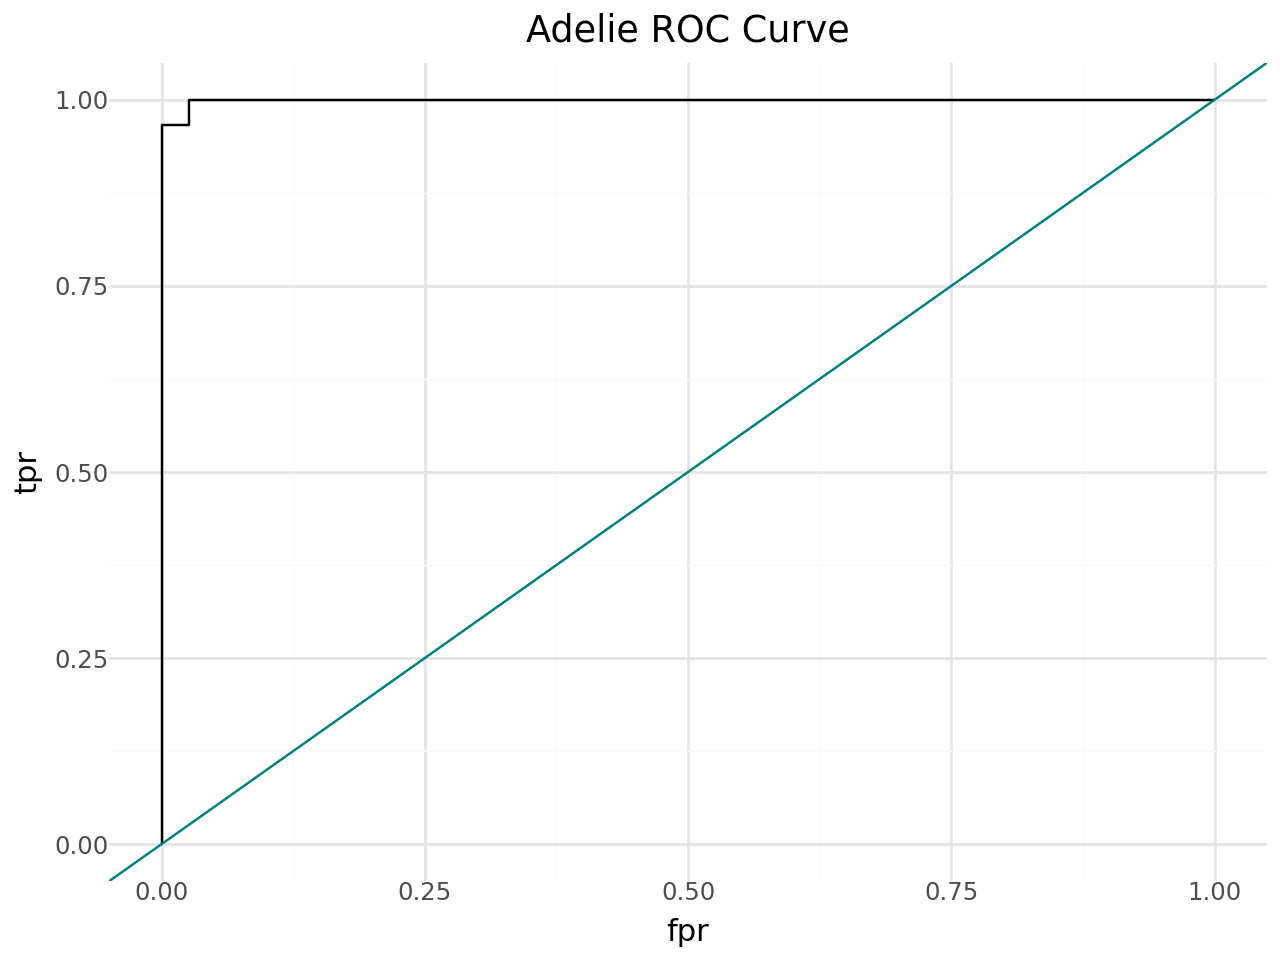

In [27]:
species = "Adelie"
model = knn3
class_idx = list(model.classes_).index(species)

probs = model.predict_proba(X_test_scaled)
fpr, tpr, _ = roc_curve((y_test == species).astype(int), probs[:, class_idx])

df_plot = pd.DataFrame({"fpr": fpr, "tpr": tpr})

(ggplot(df_plot, aes(x="fpr", y="tpr"))
    + geom_line()
    + geom_abline(color = "teal")
    + labs(title=f"Adelie ROC Curve")
    + theme_minimal())
